# Importação das bibliotecas necessárias

In [1]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

# Desenvolvimento da regressão logística 

In [2]:
data = load_boston()
housing_dataset = pd.DataFrame(data["data"], columns=data["feature_names"])
housing_dataset["TARGET"] = data["target"]
housing_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
#Esqueleto do modelo
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def forward(self, x):
    pass

In [4]:
#Modelo de regressão linear
class LinearModel(nn.Module):
  def __init__(self, x_shape, y_shape):
    super().__init__()
    self.linear = nn.Linear(x_shape, y_shape)

  def forward(self, x):
    return self.linear(x)

In [5]:
#Obtenção de dados de treino e validação e normalização
x_train, x_val, y_train, y_val = train_test_split(housing_dataset.drop(columns="TARGET").values, 
                                                  housing_dataset["TARGET"].values, 
                                                  test_size=0.20, 
                                                  random_state=0)
SC = StandardScaler()
x_train = SC.fit_transform(x_train)
x_val = SC.transform(x_val)

In [6]:
def train_validate_model(model, loss_fn, metric, lr, epochs, data_train, data_val):
  """
  This function train and validate a neural network.

  Parameters :
  ------------

  model : PyTorch model
    PyTorch model to train
  loss : .backward() compatible loss function
    loss function to train the model
  lr : float
    learning rate value
  epochs : int
    number of training epochs
  data_train : list
    list that contais in position 0 x_train data and in position 1 y_train
  data_val : list
    list that contais in position 0 x_val data and in position 1 y_val
  metric :  metric function
    metric to be applied in the results

  Returns : pd.DataFrame
    This functions returns the information generated during training about loss
    and metric.
  """
  loss_epoch_train = np.zeros(epochs)
  loss_epoch_val = np.zeros(epochs)
  metric_epoch_train = np.zeros(epochs)
  metric_epoch_val = np.zeros(epochs)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss = loss_fn
  for e in range(epochs):
    optimizer.zero_grad()
    y_predicted = model(torch.tensor(data_train[0]).float())
    loss_value = loss(y_predicted, torch.tensor(data_train[1].reshape(-1, 1)).float())
    loss_value.backward()
    optimizer.step()
    loss_epoch_train[e] = loss_value.item()
    metric_epoch_train[e] = metric(data_train[1], y_predicted.detach().numpy().reshape(-1))
    with torch.no_grad():
      y_predicted = model(torch.tensor(data_val[0]).float())
      loss_value = loss(y_predicted, torch.tensor(data_val[1].reshape(-1, 1)).float())
      loss_epoch_val[e] = loss_value.item()
      metric_epoch_val[e] = metric(data_val[1], y_predicted.detach().numpy().reshape(-1))
  return pd.DataFrame(data={"Epoch":np.arange(0, epochs), 
                            "Train loss": loss_epoch_train, 
                            "Train metric": metric_epoch_train, 
                            "Val loss": loss_epoch_val,
                            "Val metric": metric_epoch_val})

In [7]:
LR = LinearModel(13, 1)
df = train_validate_model(LR, nn.MSELoss(), mean_squared_error, 1, 100, [x_train, y_train], [x_val, y_val])

# Análise dos resultados - Regressão linear

In [8]:
df.head()

,Epoch,Train loss,Train metric,Val loss,Val metric
0,0,601.575623,601.575593,566.171448,566.171430
1,1,523.306946,523.306932,549.033203,549.033209
2,2,489.541931,489.541928,481.940857,481.940895
3,3,431.774445,431.774473,413.038330,413.038350
4,4,379.345032,379.345057,365.231323,365.231317


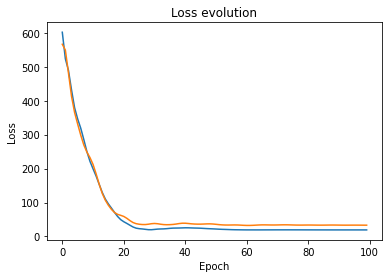

In [9]:
plt.plot(df["Epoch"], df["Train loss"])
plt.plot(df["Epoch"], df["Val loss"])
plt.title("Loss evolution")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

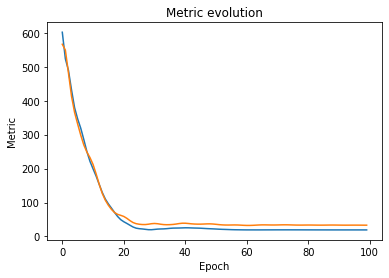

In [10]:
plt.plot(df["Epoch"], df["Train metric"])
plt.plot(df["Epoch"], df["Val metric"])
plt.title("Metric evolution")
plt.ylabel("Metric")
plt.xlabel("Epoch")
plt.show()

# Desenvolvimento da regressão logística 

In [11]:
# diabetes_dataset = pd.read_csv("data/diabetes.csv")
diabetes_dataset = pd.read_csv("..data/diabetes.csv")
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
#Modelo de regressão logística
class LogisticModel(nn.Module):
  def __init__(self, x_shape, y_shape):
    super().__init__()
    self.linear = nn.Linear(x_shape, y_shape)

  def forward(self, x):
    x = self.linear(x)
    return torch.sigmoid(x)

In [13]:
#Obtenção de dados de treino e validação e normalização
x_train, x_val, y_train, y_val = train_test_split(diabetes_dataset.drop(columns=["Outcome"]).values, 
                                                  diabetes_dataset["Outcome"].values, 
                                                  test_size=0.20,
                                                  stratify=diabetes_dataset["Outcome"].values, 
                                                  random_state=0)
SC = StandardScaler()
x_train = SC.fit_transform(x_train)
x_val = SC.transform(x_val)

In [14]:
LR = LogisticModel(8, 1)
df = train_validate_model(LR, nn.BCELoss(), roc_auc_score, 0.01, 250, [x_train, y_train], [x_val, y_val])

# Análise dos resultados - Regressão logística

In [15]:
df.head()

,Epoch,Train loss,Train metric,Val loss,Val metric
0,0,0.783524,0.322886,0.785642,0.283148
1,1,0.771992,0.331717,0.773360,0.296296
2,2,0.760850,0.342243,0.761511,0.308889
3,3,0.750107,0.353470,0.750104,0.321481
4,4,0.739771,0.366121,0.739146,0.336852


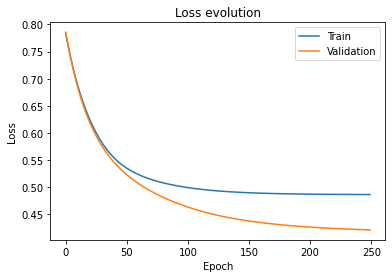

In [16]:
plt.plot(df["Epoch"], df["Train loss"])
plt.plot(df["Epoch"], df["Val loss"])
plt.title("Loss evolution")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

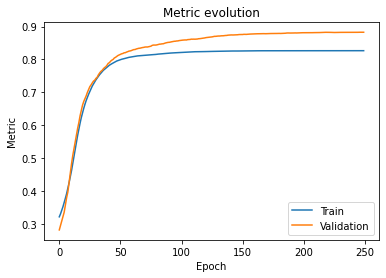

In [17]:
plt.plot(df["Epoch"], df["Train metric"])
plt.plot(df["Epoch"], df["Val metric"])
plt.title("Metric evolution")
plt.ylabel("Metric")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

## Determinação dos fatores de risco

In [18]:
weights = (list(LR.parameters())[0].data).numpy()

In [19]:
risk_factors = pd.DataFrame(weights, columns=diabetes_dataset.columns[:-1])
risk_factors = risk_factors.T
risk_factors.columns = ["FACTORS"]

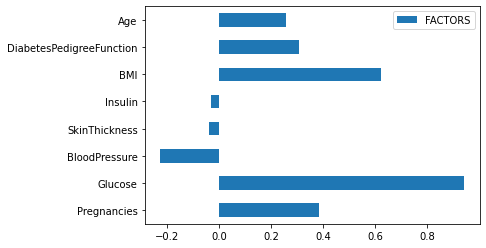

In [20]:
risk_factors.plot(kind="barh")
plt.show()